This document will guide you through using the Overcooked-Plus project.


Overcooked-Plus is based on OpenAI's gym library and shares many common usage methods.
The following example introduces how to create a single-player environment.

First, create the environment using the environment creation tool provided in overcookedPlus.env_creater. The tool includes three presets: easy, medium, and hard. You can also customize the environment by inputting your own parameters.

In [ ]:
from overcookedPlus.env_creater import create_env

# Custom rewards
rewardList = {
    "subtask finished": 10,
    "correct delivery": 200,
    "wrong delivery": -5,
    "step penalty": -0.1,
    "burned penalty": -2,
}

# Create an environment using a preset
env = create_env(preset="medium", n_agent=1, GUI=True)
# Detailed customization of the environment, settings equivalent to preset="medium"
# env = create_env(map_name="mapB", rewardList, n_agent=1, obs_mode="vector", obs_radius=2, dynamic_map=False, agent_communication=False, GUI=True)


Reset the environment state and retrieve observations using env.reset(). The observations (obs) are a list for n_agents. In obs_mode="vector", each item is a (35,) vector. In obs_mode="image", it consists of RGB vectors centered on the agent.


In [7]:
obs = env.reset()
print(obs, obs[0].shape)

[array([0.        , 0.71428571, 0.        , 0.        , 0.57142857,
       0.        , 0.        , 0.14285714, 0.        , 0.85714286,
       0.42857143, 0.57142857, 0.        , 0.71428571, 0.        ,
       0.28571429, 0.        , 0.14285714, 0.14285714, 0.28571429,
       0.85714286, 0.        , 0.28571429, 0.        , 0.        ,
       0.85714286, 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ])] (35,)


The environment progresses through the function new_obs, reward, done, info = env.step(action).


In [ ]:
obs, reward, done, info = env.step([0])

The action is also a list corresponding to the number of agents, each agent's action space is:


In [8]:
env.action_space

Discrete(5)

Integer values 0-3 correspond to the actions ["right", "down", "left", "up"], and any other value is interpreted as "wait".


After executing env.step(), the environment returns a tuple containing four elements: obs is the latest observation state after applying the action, reward is a list containing the reward or penalty each agent received after applying the action. Done indicates whether the current episode has ended, and info provides additional information.


In [10]:
print(obs, reward, done, info)

[array([0.        , 0.71428571, 0.        , 0.        , 0.57142857,
       0.        , 0.        , 0.14285714, 0.        , 0.85714286,
       0.42857143, 0.57142857, 0.        , 0.71428571, 0.        ,
       0.28571429, 0.        , 0.14285714, 0.14285714, 0.28571429,
       0.85714286, 0.        , 0.28571429, 0.        , 0.        ,
       0.85714286, 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ])] [-0.1] False {'cur_mac': [0], 'mac_done': [True], 'collision': []}


The env.render() function uses the pygame package to render the game screen. If GUI is set to True when initializing the environment, it will automatically render the latest environment scene each time the step function is executed.


In [12]:
rgb_array=env.render()

Below is an example of a single-agent environment operated by a human, where the action is obtained through keyboard input. The keys 'WASD' correspond to movements in different directions.


In [ ]:
import pygame

from overcookedPlus.utils.utils import key2action
from overcookedPlus.env_creater import create_env

env = create_env(preset="medium", n_agent=1, GUI=True)
env.reset()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
        elif event.type == pygame.KEYDOWN:
            key = pygame.key.name(event.key)
            print(f"Key: {key}")
            action = key2action(key)
            if action is not None:
                new_obs, reward, done, info = env.step([action])
                print(f"Reward: {reward}, Done: {done}, Info: {info}")
                obs = new_obs
pygame.quit()

You can access the reward history through the env.agent's reward attribute, the current environment steps through env.env_step, and completed tasks information through env.task_Manager.completed_tasks.


In [2]:
env.env_step

200

In [4]:
env.task_Manager.completed_tasks

[{'ingredients': ('onion',),
  'task_encoding': [0, 0, 1, 0],
  'task_start_time': 0,
  'task_end_time': 40},
 {'ingredients': ('onion',),
  'task_encoding': [0, 0, 1, 0],
  'task_start_time': 0,
  'task_end_time': 40},
 {'ingredients': ('tomato', 'lettuce', 'onion', 'steak'),
  'task_encoding': [1, 1, 1, 1],
  'task_start_time': 19,
  'task_end_time': 153}]

Below is a simple example of result analysis

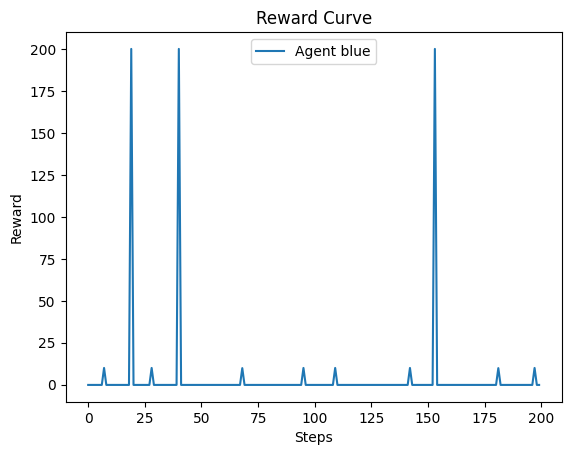

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title("Reward Curve")
plt.xlabel("Steps")
plt.ylabel("Reward")
for agent in env.agent:
    plt.plot(agent.reward, label=f"Agent {agent.color}")
plt.legend()
plt.show()

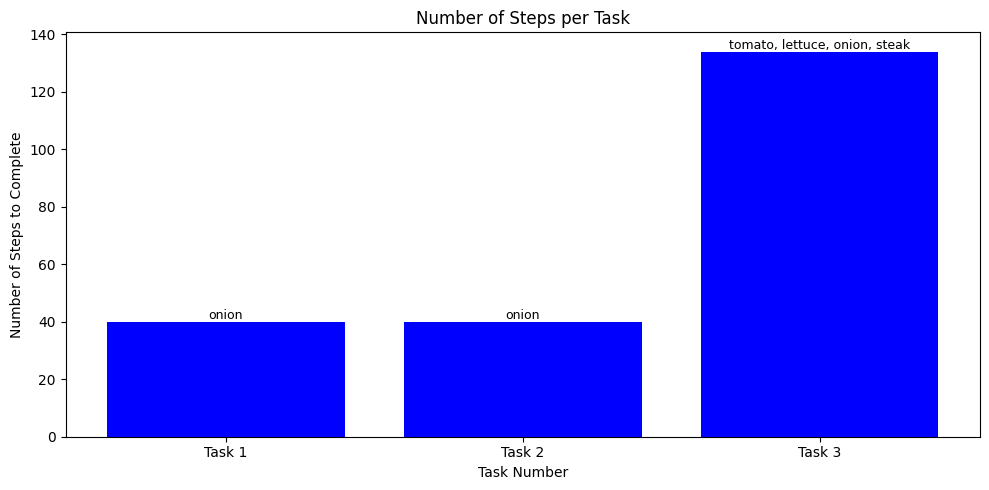

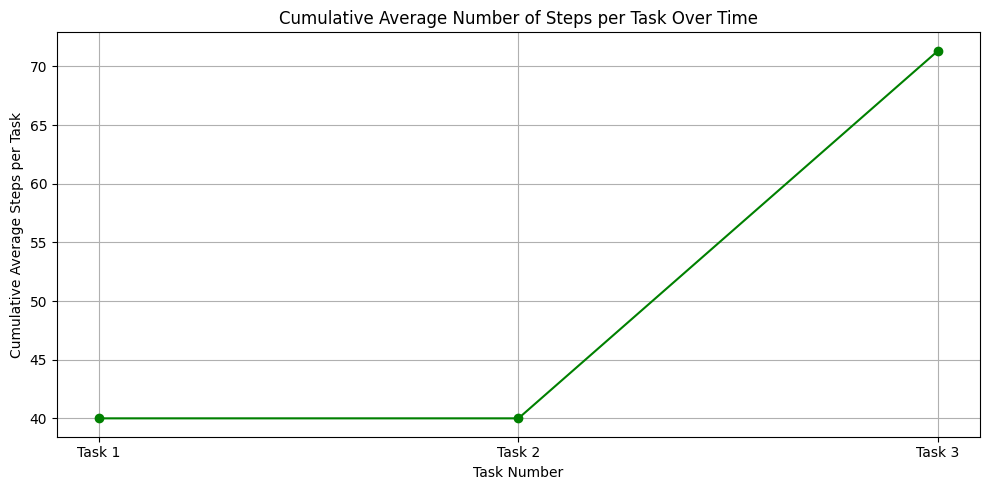

In [7]:
# Import necessary libraries for data handling and visualization
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the list of completed tasks from the task manager
completed_tasks = env.task_Manager.completed_tasks

# Calculate the number of steps taken to complete each task
task_steps = [task['task_end_time'] - task['task_start_time'] for task in completed_tasks]

# Generate a list of indices for the tasks to serve as labels on the x-axis
task_indices = range(1, len(completed_tasks) + 1)

# Create labels for each task based on the ingredients involved
ingredient_labels = [', '.join(task['ingredients']) for task in completed_tasks]

# Create a bar chart to visualize the number of steps per task
plt.figure(figsize=(10, 5))
bars = plt.bar(task_indices, task_steps, color='blue')
plt.xlabel('Task Number')  # Label for the x-axis
plt.ylabel('Number of Steps to Complete')  # Label for the y-axis
plt.title('Number of Steps per Task')  # Title of the plot
plt.xticks(task_indices, labels=[f"Task {i+1}" for i in range(len(completed_tasks))])  # Set x-axis tick labels

# Annotate each bar with the corresponding ingredients for additional information
for bar, label in zip(bars, ingredient_labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()  # Adjust layout to make room for annotations
plt.show()  # Display the plot

# Calculate the cumulative average of steps over time to analyze efficiency improvements
average_steps_over_time = np.cumsum(task_steps) / np.arange(1, len(task_steps) + 1)

# Plot the cumulative average steps over time
plt.figure(figsize=(10, 5))
plt.plot(task_indices, average_steps_over_time, marker='o', linestyle='-', color='green')
plt.xlabel('Task Number')  # Label for the x-axis
plt.ylabel('Cumulative Average Steps per Task')  # Label for the y-axis
plt.title('Cumulative Average Number of Steps per Task Over Time')  # Title of the plot
plt.xticks(task_indices, labels=[f"Task {i+1}" for i in range(len(completed_tasks))])  # Set x-axis tick labels
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot


Additionally, the agent class records the log of movement coordinates, which can be used to display a heatmap of movements.

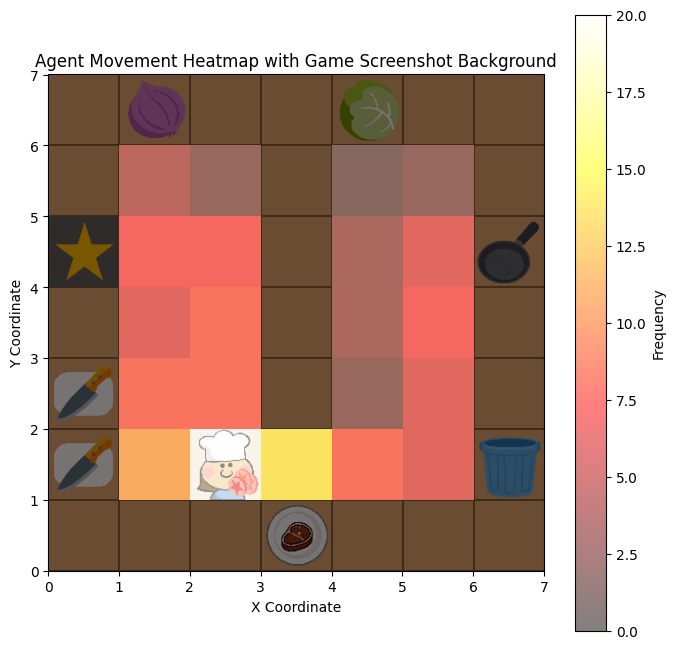

In [8]:
loc_log = env.agent[0].loc_log
game_screenshot=env.preception_Manager._get_image_state()[0]
# Create a heatmap based on loc_log
heatmap = np.zeros((env.map_Manager.dimensions))
for loc in loc_log:
    heatmap[loc] += 1

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
# Display the game screenshot
ax.imshow(game_screenshot, extent=(0, 7, 0, 7), alpha=1)

# Display the heatmap on top
ax.imshow(heatmap, cmap='hot', interpolation='nearest', extent=(0, 7, 0, 7), alpha=0.1)

ax.set_title('Agent Movement Heatmap with Game Screenshot Background')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.colorbar(ax.imshow(heatmap, cmap='hot', interpolation='nearest', extent=(0, 7, 0, 7), alpha=0.5), label='Frequency')
plt.show()

Below is an example using the PPO reinforcement learning method from the stable-baselines3 library, published by OpenAI. (Note: Additional dependencies need to be installed to execute this.) 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\pureb\anaconda3\envs\GA\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\pureb\anaconda3\envs\GA\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\pureb\anaconda3\envs\GA\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\pureb\anaconda3\envs\GA\lib\site-packages\gym\utils\passive_env_checker.py:195

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -20.5    |
| time/              |          |
|    fps             | 555      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -20.2       |
| time/                   |             |
|    fps                  | 545         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009979065 |
|    clip_fraction        | 0.0822      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.00328     |
|    learning_rate        | 0.

c:\Users\pureb\anaconda3\envs\GA\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-20.00 +/- 0.00
Episode length: 200.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 200         |
|    mean_reward          | -20         |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.006446409 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.157       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.136       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00258    |
|    value_loss           | 0.346       |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -20.2    

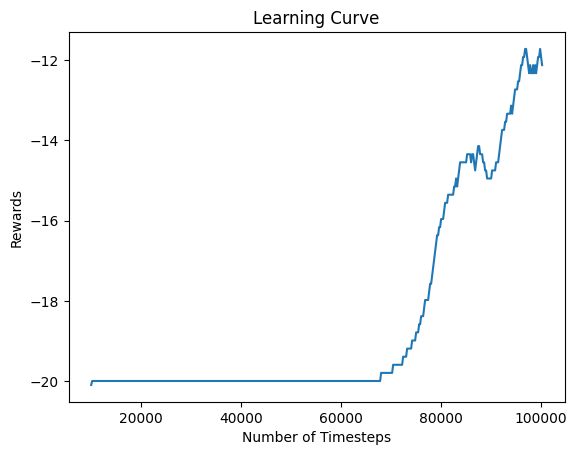

In [1]:
from gym import spaces
import numpy as np
import os
import shimmy
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env.patch_gym import _convert_space, _patch_env
import matplotlib.pyplot as plt

from overcookedPlus.utils.utils import key2action
from overcookedPlus.env_creater import create_env


# Create environment and wrap it with Monitor
env = create_env(preset="easy", n_agent=1, GUI=False, obs_mode="vector", fixed_task=True, max_ing=1)
env = _patch_env(env)
env = Monitor(env, filename="./logs")
# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Callbacks
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/', name_prefix='ppo_model')
eval_callback = EvalCallback(env, best_model_save_path='./logs/best_model',
                             log_path='./logs/results', eval_freq=5000,
                             deterministic=True, render=False)

# Train the model
model.learn(total_timesteps=100000, callback=[checkpoint_callback, eval_callback])

# Save the model
model.save("ppo_overcooked_model")

# Load the model
model = PPO.load("ppo_overcooked_model")

# Predict
obs = env.reset()
action, _states = model.predict(obs, deterministic=True)

# Evaluate the model
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

# Plot the learning curve
def plot_learning_curve(log_dir):
    import pandas as pd
    import matplotlib.pyplot as plt
    from stable_baselines3.common.results_plotter import ts2xy, load_results

    results = load_results(log_dir)
    x, y = ts2xy(results, 'timesteps')
    y = pd.Series(y).rolling(window=50).mean()  # Moving average
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title('Learning Curve')
    plt.show()

plot_learning_curve('./logs')